In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import calendar
from datetime import datetime
import os
pd.options.display.float_format = "{:.2f}".format
#from tqdm import tqdm
from matplotlib import cm

In [2]:
def group_by_fare(x):
    if x >= 2 and x < 50:
        return '2-50'
    elif x < 100:
        return '51-100'
    elif x < 200:
        return '101-200'
    else:
        return '>200'

In [3]:
train = pd.read_csv(r'D:\PycharmProjects\TaxiPrediction\train.csv',nrows = 1000000,parse_dates=['pickup_datetime'])

In [4]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.50,2009-06-15 17:26:21+00:00,-73.84,40.72,-73.84,40.71,1
1,2010-01-05 16:52:16.0000002,16.90,2010-01-05 16:52:16+00:00,-74.02,40.71,-73.98,40.78,1
2,2011-08-18 00:35:00.00000049,5.70,2011-08-18 00:35:00+00:00,-73.98,40.76,-73.99,40.75,2
3,2012-04-21 04:30:42.0000001,7.70,2012-04-21 04:30:42+00:00,-73.99,40.73,-73.99,40.76,1
4,2010-03-09 07:51:00.000000135,5.30,2010-03-09 07:51:00+00:00,-73.97,40.77,-73.96,40.78,1


__Features__
* pickup_datetime - timestamp value indicating when the taxi ride started.
* pickup_longitude - float for longitude coordinate of where the taxi ride started.
* pickup_latitude - float for latitude coordinate of where the taxi ride started.
* dropoff_longitude - float for longitude coordinate of where the taxi ride ended.
* dropoff_latitude - float for latitude coordinate of where the taxi ride ended.
* passenger_count - integer indicating the number of passengers in the taxi ride.

__Target__
* fare_amount - float dollar amount of the cost of the taxi ride. This value is only in the training set; this is what you are predicting in the test set and it is required in your submission CSV.

__I will analyse only 1kk sample of data (Size of whole data is 55kk)__

In [5]:
train.shape

(1000000, 8)

In [6]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.00,1000000.00,1000000.00,999990.00,999990.00,1000000.00
mean,11.35,-72.53,39.93,-72.53,39.92,1.68
std,9.82,12.06,7.63,11.32,8.20,1.32
min,-44.90,-3377.68,-3116.29,-3383.30,-3114.34,0.00
25%,6.00,-73.99,40.73,-73.99,40.73,1.00
50%,8.50,-73.98,40.75,-73.98,40.75,1.00
75%,12.50,-73.97,40.77,-73.96,40.77,2.00
max,500.00,2522.27,2621.63,45.58,1651.55,208.00


__Let's look on description of out 1kk sample__
* We can see that mean fare amount is: __11.35__
* Minimal fare amount is: __-44.90__ - so it's negative fare amount is impossible. We should drop outliers
* Maximum Fare amount is: __500__ 
* Standard deviation is:  __9.82__
* Min number of passangers in taxi raid: __0__ - > we need to check it
* Average number of passangers in taxi raid: __1.68__ 

In [7]:
train.isnull().sum().to_frame().T

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,0,0,0,0,10,10,0


In [8]:
train['passenger_count'].value_counts()

1      691344
2      148105
5       70595
3       43765
4       21429
6       21196
0        3565
208         1
Name: passenger_count, dtype: int64

In [9]:
train = train[(train['fare_amount']>=2) & (train['passenger_count']<208)]
train = train.dropna()

In [10]:
train['fare_group'] = train['fare_amount'].apply(lambda x: group_by_fare(x))

In [11]:
train.shape

(999912, 9)

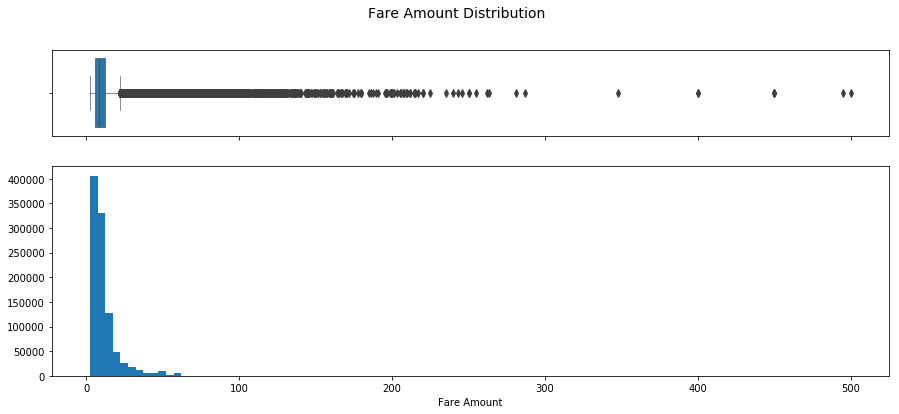

In [54]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(15,6),gridspec_kw={"height_ratios": (.35, .85)})
c1 = sns.boxplot(train['fare_amount'], ax=ax_box,linewidth=0.6)
c2 = train['fare_amount'].hist(bins=100,ax=ax_hist,grid=False);
c1.set_xlabel('');
c2.set_xlabel('Fare Amount');
plt.suptitle('Fare Amount Distribution',fontsize=14);

In [23]:
fg = list(train['fare_group'].unique())
fg

['2-50', '51-100', '101-200', '>200']

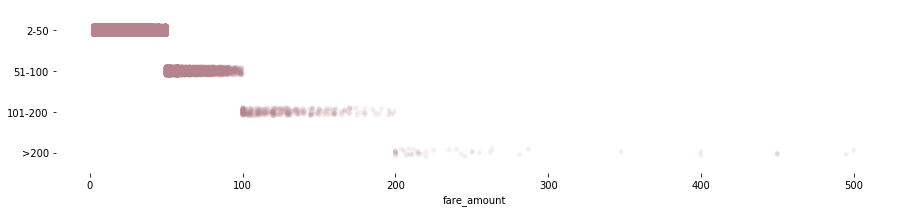

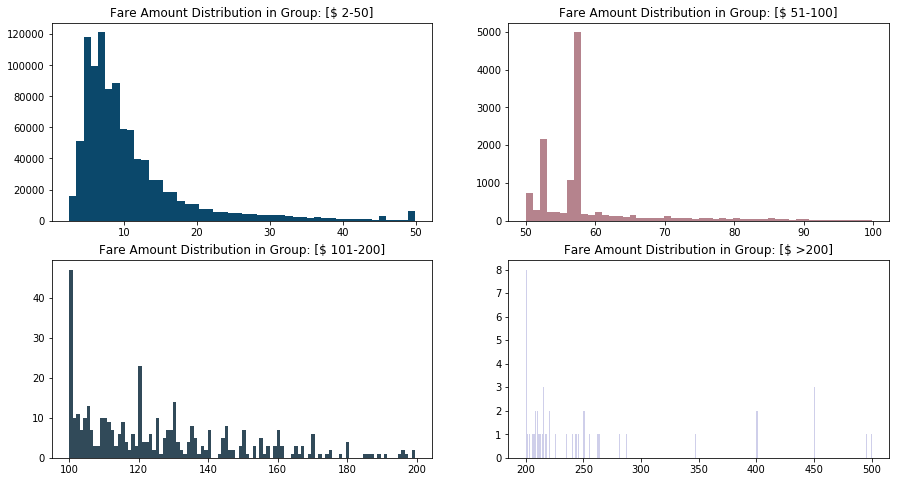

In [66]:
plt.figure(figsize=(15,3))
s1 = sns.stripplot(y='fare_group',x='fare_amount',data = train,
                   jitter=True, 
                   marker='o', 
                   alpha=0.12,
                   color='#B5838D')
sns.despine(left=True,bottom=True)
f,ax = plt.subplots(2,2,figsize=(15,8))
train[train['fare_group']==fg[0]]['fare_amount'].hist(color='#0B486B',grid=False,ax=ax[0][0],bins=48).set_title(f'Fare Amount Distribution in Group: [$ {fg[0]}]')
train[train['fare_group']==fg[1]]['fare_amount'].hist(color='#B5838D',grid=False,ax=ax[0][1],bins=50).set_title(f'Fare Amount Distribution in Group: [$ {fg[1]}]')
train[train['fare_group']==fg[2]]['fare_amount'].hist(color='#314A59',grid=False,ax=ax[1][0],bins=100).set_title(f'Fare Amount Distribution in Group: [$ {fg[2]}]')
train[train['fare_group']==fg[3]]['fare_amount'].hist(color='#CFCFEA',grid=False,ax=ax[1][1],bins=300).set_title(f'Fare Amount Distribution in Group: [$ {fg[3]}]');

In [83]:
f_pct = pd.DataFrame(train['fare_group'].value_counts()/sum(train['fare_group'].value_counts())*100)
f_p = pd.DataFrame(train['fare_group'].value_counts())

In [94]:
f_grp = pd.concat([f_p,f_pct],axis=1)
f_grp.columns=['count','pct%']
f_grp.T

,2-50,51-100,101-200,>200
count,986867.00,12610.00,389.00,46.00
pct%,98.70,1.26,0.04,0.00


In [106]:
f0 = pd.DataFrame(train[train['fare_group']==fg[0]]['fare_amount'].describe())
f1 = pd.DataFrame(train[train['fare_group']==fg[1]]['fare_amount'].describe())
f2 = pd.DataFrame(train[train['fare_group']==fg[2]]['fare_amount'].describe())
f3 = pd.DataFrame(train[train['fare_group']==fg[3]]['fare_amount'].describe())
f_desc = pd.concat([f0,f1,f2,f3],axis=1)
f_desc.columns=['2-50','51-100','101-200','>200']
f_desc.T

,count,mean,std,min,25%,50%,75%,max
2-50,986867.00,10.69,7.70,2.50,6.00,8.50,12.50,49.90
51-100,12610.00,58.52,8.32,50.00,52.76,57.33,57.54,99.75
101-200,389.00,125.99,23.67,100.00,105.58,120.00,139.50,199.50
>200,46.00,259.32,87.50,200.00,206.26,216.00,260.28,500.00


__We can see statistics about fare amount divide by fare amount groups:__
* __In our 1kk sample 75% of Fare Amount for ride was <= 12.5 dollars, 98.7% of fare amounts were <50 dollars__
    * in group 2-50 dollars mean fare: 10.69 dollars, 75% of fare amount for taxi raid was < 12.50 dollars
    * in group 51-100 dollars mean fare: 58.52 dollars, 75% of fare amount for taxi raid was < 57.54 dollars
    * in group 101-200 dollars mean fare: 125.99 dollars,  75% of fare amount for taxi raid was < 139.50 dollars
    * in group 201-500 dollars mean fare: 259.32 dollars,  75% of fare amount for taxi raid was < 260.28 dollars